# Распознавание рукописных цифр

In [4]:
# Pytorch modules
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Sklearn metcirs
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

#Import math libs
import random
import numpy as np

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mlxtend.plotting import plot_confusion_matrix

#Status bar
from tqdm.notebook import tqdm

# Load files
import json
import os
import pandas as pd
import pickle

# Usefull functions
from collections import namedtuple
import itertools

# Helper functions

Датасет:  [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer "")

Задание 1. Разбить выборку на три части в функции load_data

In [7]:
def rand_diap(num, diap):
        low = np.log(diap[0])
        high = np.log(diap[1])
        tmp = np.random.rand(num)
        tmp *= high - low
        tmp += low
        return np.exp(tmp)

    
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()
    for instance in itertools.product(*vals):
        yield dict(zip(keys, instance))

        
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    g = torch.Generator()
    g.manual_seed(seed)
    return g
    
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
    
def extract_parameters(x, name):
    name += '_'
    x_out = {}
    for i in x:
        if name in i:
            key = i.replace(name, '')
            x_out[key] = x[i]
    return x_out


def load_data():
    df = pd.read_csv('MNIST.csv')

    # Your code here
    
    return df_train, df_val, df_test

# Constants

In [8]:
WORK_DIR = 'work/'

IMAGE_SIZE = 28 # Размер изображений
OUTPUT_SIZE = 10 # Кол-во классов
EPOCHS_NUM = 500 # Максимальное кол-во эпох
METRIC = accuracy_score # Функция для рачета точности
METRIC_NAME = 'accuracy_score' # Название метрики
CRITERION = nn.CrossEntropyLoss() # Функция потерь
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
MODEL_NAME = 'CNN'

# Гиперпараметры
HYP_DICT = {'cnn_use_do': [False],
            'cnn_use_bn': [True],
            'cnn_activation': ['relu'],
            'scheduler': ['step'],
            'reg_coef': [1e-3],
            'learning_rate': [1e-3],
            'optimizer': ['adam'],
            'use_transforms': [True]}

# Трансформации для обучения
TR = transforms.Compose([transforms.RandomRotation(30)])

# Трансформации для тестирования
TR_INF = transforms.Compose([transforms.Grayscale(),
                             transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                             transforms.ToTensor()])

                
HYPS = list(product_dict(**HYP_DICT))
                    
G = seed_everything(42)

# Разбиение на выборки
DF_TRAIN, DF_VAL, DF_TEST = load_data()

display(DF_TRAIN)
display(DF_VAL)
display(DF_TEST)

NameError: name 'df_train' is not defined

# Create datasets

Задание 2. Реализовать датасет. Использовать DF_TRAIN, DF_VAL, DF_TEST. Параметр mode указывает на соответствующую выборку. Для преобразования данных в изображение использовать метод reshape.

In [4]:
class DefectsDataset(torch.utils.data.Dataset):
    """Реализация датасета
    Атрибуты:
        inputs - массив (тензор) с входными данными формата (N, IMAGE_SIZE, IMAGE_SIZE) и типом данных float32
        labels - вектор разметки c типом данных int64
    """
    def __init__(self, mode, transforms=None):
        if mode == 'train':
            df = DF_TRAIN
        elif mode == 'train':
            df = DF_VAL
        else:
            df = DF_TEST
            
        self.transforms = transforms
            
        # Your code here
        
        self.inputs = torch.tensor(self.inputs)

    def __getitem__(self, index):
        """Метод, возвращающий пару image, label по индексу"""
        if self.transforms is not None:
            image = self.transforms(self.inputs[index].unsqueeze(0))
        else:
            image = self.inputs[index].unsqueeze(0)
        return (image / 255) - 0.5, self.labels[index]
    
    def __len__(self):
        """Размер датасета"""
        return len(self.labels)

# Create callback for train process

In [5]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        self.best_monitor = None
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.best_monitor is None or self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.best_monitor is None or self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.7f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        self.best_monitor = None
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.best_monitor is None or self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.best_monitor is None or self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.7f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

# Functions for work with model

In [6]:
def predict(loader, model):
    """Выполнение предсказаний модели"""
    model.eval()
    
    bs = loader.batch_size
    
    inputs_all = torch.zeros(len(loader.dataset), 1, IMAGE_SIZE, IMAGE_SIZE)
    labels_all = torch.zeros(len(loader.dataset), dtype=torch.int64)
    outputs_all = torch.zeros(len(loader.dataset), OUTPUT_SIZE)

    for i, (inputs, labels) in enumerate(iter(loader)):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        outputs = model.forward(inputs)
        
        labels_all[bs * i:bs * i + len(inputs)] = labels.cpu()
        inputs_all[bs * i:bs * i + len(inputs)] = inputs.cpu()
        outputs_all[bs * i:bs * i + len(inputs)] = outputs.cpu()

    model = None
    inputs = None
    labels = None
    outputs = None
    sm = None

    torch.cuda.empty_cache()

    return inputs_all, labels_all, outputs_all


def evaluate(inputs, labels, outputs):
    """Оценка модели"""
    return CRITERION(outputs, labels).item(), METRIC(labels, nn.functional.softmax(outputs, 1).argmax(1))


def train(model, train_loader, val_loader, optimizer, epochs=20,
          print_every=10, callbacks=None, lr_scheduler=None):
    """Make train process.

    Args:
        model (Model): Model for training.
        train_loader (DataLoader): loader with train data.
        val_loader (DataLoader): loader with validation data.
        optimizer (Optimizer): Optimizer.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks

    Returns:
        history (dict): Dict of lists with train history.
    """

    history = {'Train loss': [],
               'Val loss': [],
               'Train {}'.format(METRIC_NAME): [],
               'Val {}'.format(METRIC_NAME): []}

    if callbacks:
        for i in callbacks:
            i.start(history, model)

    for e in range(epochs):
        model.train()

        running_loss = 0

        stop = False

        steps = 0
        
        running_metric = 0

        train_print = ''
        bar = tqdm(range(len(train_loader)), desc="Epoch {}/{}".format(e + 1, epochs), postfix=train_print)

        for inputs, labels in iter(train_loader):
            steps += 1

            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model.forward(inputs)
            
            loss = CRITERION(outputs, labels)

            loss.backward()
            
            optimizer.step()

            with torch.no_grad():
                running_loss += loss.item()

                running_metric += METRIC(labels.cpu(), nn.functional.softmax(outputs, 1).argmax(1).cpu())

            if steps % print_every == 0:
                train_print = (f"Train loss: {running_loss / steps:.7f}, "
                               f"Train {METRIC_NAME}: {running_metric / steps:.7f}")

                bar.postfix = train_print
                model.train()

            if steps != len(train_loader):
                bar.update()

        with torch.no_grad():
            val_evaluate = evaluate(*predict(val_loader, model))

        train_print = (f"Train loss: {running_loss / steps:.7f}, "
                       f"Train {METRIC_NAME}: {running_metric / steps:.7f}, "
                       f"Val loss: {val_evaluate[0]:.7f}, "
                       f"Val {METRIC_NAME}: {val_evaluate[1]:.7f}")

        history["Train loss"].append(running_loss / steps)
        history[f"Train {METRIC_NAME}"].append(running_metric / steps)
        history["Val loss"].append(val_evaluate[0])
        history[f"Val {METRIC_NAME}"].append(float(val_evaluate[1]))
        
        if lr_scheduler:
            lr_scheduler.step(val_evaluate[0])

        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text:
                    train_print += ', ' + state_text
                if state:
                    stop = True
        
        bar.postfix = train_print
        bar.update()
        bar.close()

        if stop:
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            inputs = None
            labels = None
            outputs = None
            loss = None
            torch.cuda.empty_cache()

            break

        inputs = None
        labels = None
        outputs = None
        loss = None

        torch.cuda.empty_cache()
        
    if callbacks:
        for i in callbacks:
            i.stop()

    model = None

    torch.cuda.empty_cache()
    
#     print(train_print)
    
    return history

Задание 3. Дописать функцию show_examples для визуализации примеров. Необходимо выводить примеры для соответствующих классов. Пример выполнения:
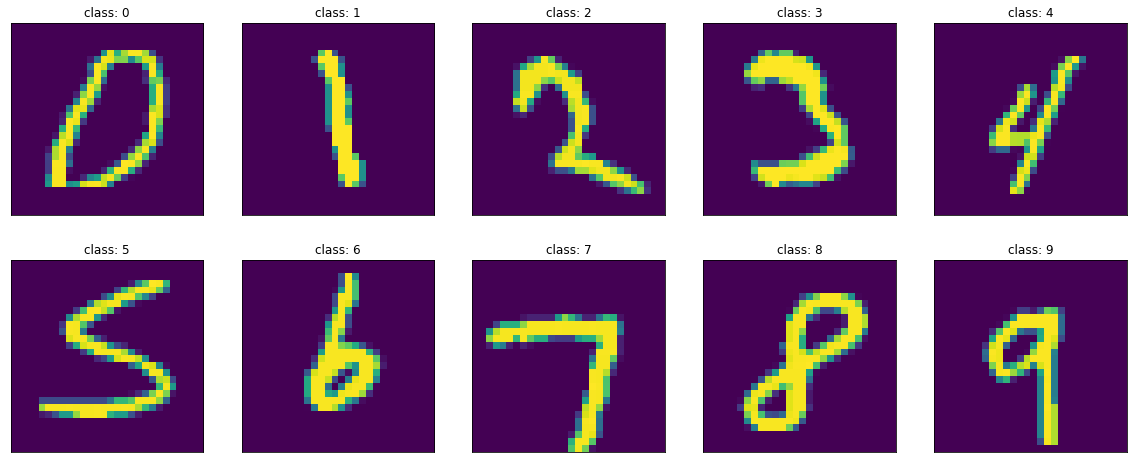

In [38]:
def show_examples(dataset, title):
    """Визуализация примеров"""
    print(title)
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (20, 8))
    
    # Your code here
    
    for i in range(2):
        for j in range(5):
            
            # Your code here
            
            ax[i, j].imshow(dataset[ind][0][0])
            ax[i, j].set_title(f'class: {dataset[ind][1]}')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    
    plt.show()


def plot_train_history(history):
    """Plot train history.

    Args:
        history (dict): Dict of lists with train history.
    """

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(17, 9))

    ax[0].plot(history['Train loss'], c='r')
    ax[0].plot(history['Val loss'], c='g')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_yscale('log')
    ax[0].legend(['Train', 'Val'])

    ax[1].plot(history[f'Train {METRIC_NAME}'], c='r')
    ax[1].plot(history[f'Val {METRIC_NAME}'], c='g')
    ax[1].set_title(METRIC_NAME)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel(METRIC_NAME)
    ax[1].set_yscale('log')
    ax[1].legend(['Train', 'Val'])

    plt.show()
    
    
def analize_history(history, parameters):
    """Анилиз гиперпараметров"""
    results_val = {}
    
    for key, train_info in run_record.items():
        tmp = []
        for parameter in parameters:
            tmp.append(train_info['hyperparams'][parameter])
        tmp = tuple(tmp)
        if tmp not in results_val:
            results_val[tmp] = [[], []]
        results_val[tmp][0].append(train_info['final_val_metric'])
        results_val[tmp][1].append((train_info['hyperparams'], key))
    
    fig, ax = plt.subplots(figsize=(20, 10))
    
    parameters_tmp = []
    results_val_best = []

    for parameter in results_val:
        result = results_val[parameter][0]
        index = result.index(min(result))
        
        parameters_tmp.append(' '.join(map(str, parameter)))
        results_val_best.append(min(result))

    print(results_val_best)
    ax.plot(parameters_tmp, results_val_best, c='g', marker='^')
    ax.set_ylabel('Monitor metric')
    ax.set_xlabel(' '.join(parameters))
    ax.legend(['Validation'])
    
    plt.show()
    
    
def plot_cm(targets, predictions, title):
    """Show confusion matrix for predictions of model.
    
    Args:
        targets (Model): Ground truth labels.
        predictions (DataLoader): Predictions of model.
        title (str): Title of CM.
    """
    predictions = nn.functional.softmax(predictions, 1).argmax(axis=1)
    
    cm  = confusion_matrix(targets, predictions)
    
    plot_confusion_matrix(cm,figsize=(6, 4),cmap=plt.cm.Blues)
    plt.xticks(range(OUTPUT_SIZE), [i for i in range(OUTPUT_SIZE)], fontsize=14)
    plt.yticks(range(OUTPUT_SIZE), [i for i in range(OUTPUT_SIZE)], fontsize=14)
    plt.xlabel('Predicted Label',fontsize=14)
    plt.ylabel('True Label',fontsize=14)
    plt.title(title + " CM")
    plt.show()
    sm = None

    
def dict2str(dict1):
    out = str(dict1).replace("}", "")
    out = str(out).replace("{", "")
    out = str(out).replace("\"", "")
    out = str(out).replace("\'", "")
    out = str(out).replace(":", "")
    return out

# CNN

Задание 4. Реализовать сверточную нейронную сеть LeNet-5:
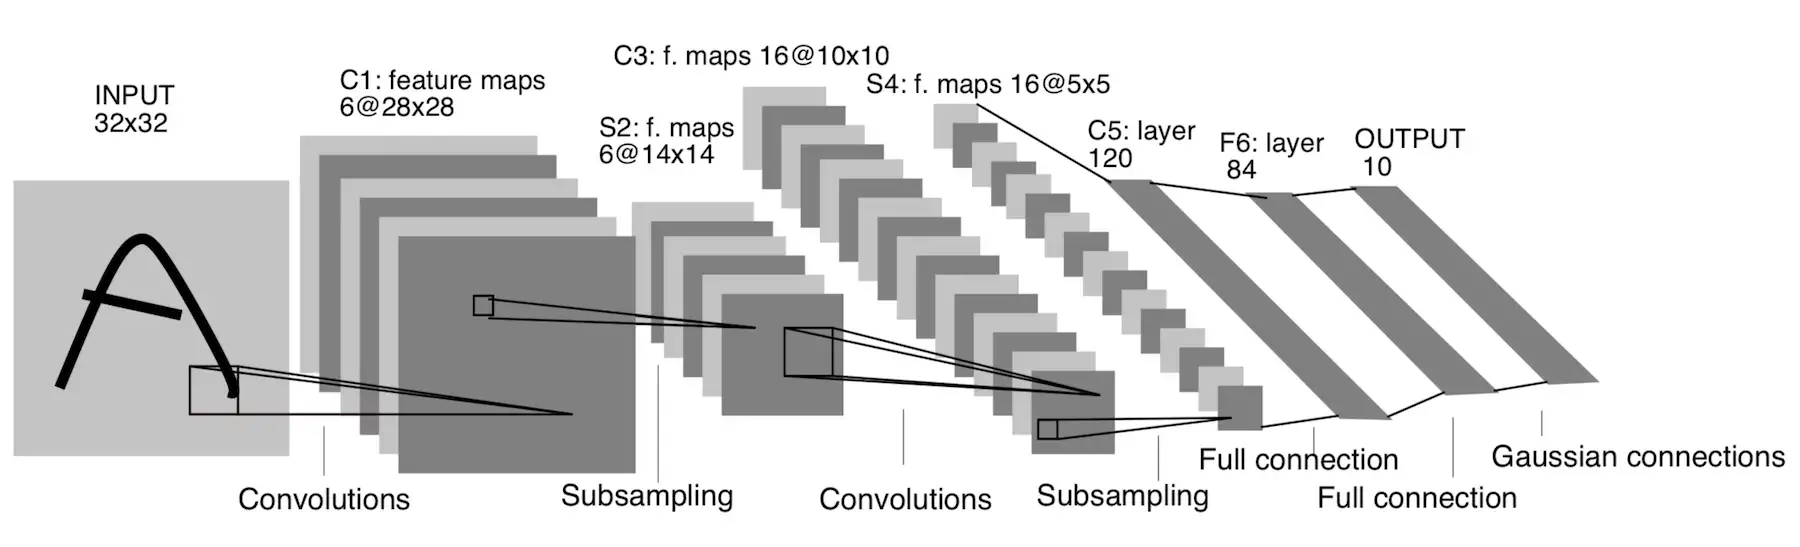
Из исходного примера необходимо оставить выбор активации, батч нормализации и слоя Dropout.

Описание работы сверточных сетей:  [Как работает сверточная нейронная сеть](https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/ "Как работает сверточная нейронная сеть")

Пример работы MaxPooling (Subsampling):
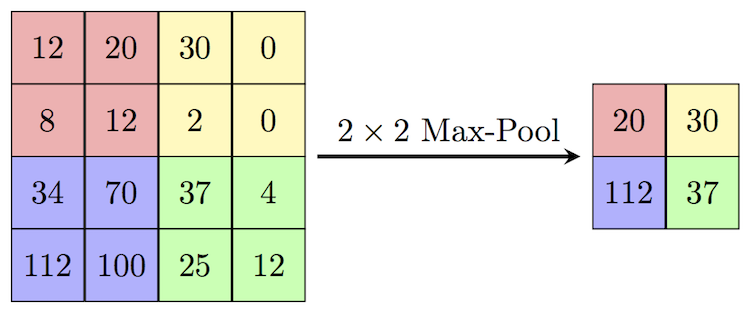


In [9]:
class CNN(nn.Module):
    """Реализация сверточной нейронной сети"""
    def __init__(self, use_do, use_bn, activation, hidden_layers=2, hidden_channels=2):
        super(CNN, self).__init__()
        
        # Your code here
        
#         layers = []
        
#         if activation == 'relu':
#             act_fcn = nn.ReLU
#         elif activation == 'leaky_relu':
#             act_fcn = nn.LeakyReLU
#         elif activation == 'tanh':
#             act_fcn = nn.Tanh
#         else:
#             act_fcn = nn.Sigmoid
            
#         for i in range(hidden_layers):
#             if not i:
#                 layers += [nn.Conv2d(1, hidden_channels, 3, stride=1, padding=1, bias=False if use_bn else True),
#                            nn.BatchNorm2d(hidden_channels) if use_bn else nn.Identity(),
#                            act_fcn(inplace=True) if 'relu' in activation else act_fcn(),
#                            nn.Dropout(0.5 if use_do else 0)]
#             else:
#                 layers += [nn.Conv2d(hidden_channels, hidden_channels, 3, stride=1, padding=1, bias=False if use_bn else True),
#                            nn.BatchNorm2d(hidden_channels) if use_bn else nn.Identity(),
#                            act_fcn(inplace=True) if 'relu' in activation else act_fcn(),]
        
#         layers.append(nn.Dropout(0.5 if use_do else 0))
#         layers.append(nn.MaxPool2d(2, 2))
#         layers.append(nn.Flatten())
#         layers.append(nn.Linear((IMAGE_SIZE // 2) ** 2 * hidden_channels, OUTPUT_SIZE))
                      
#         self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x

# Train

Train


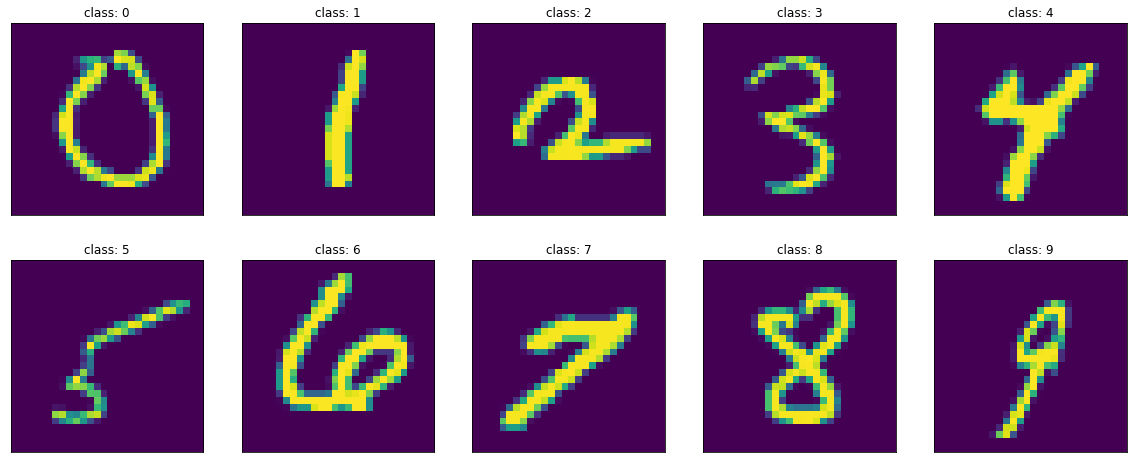

Val


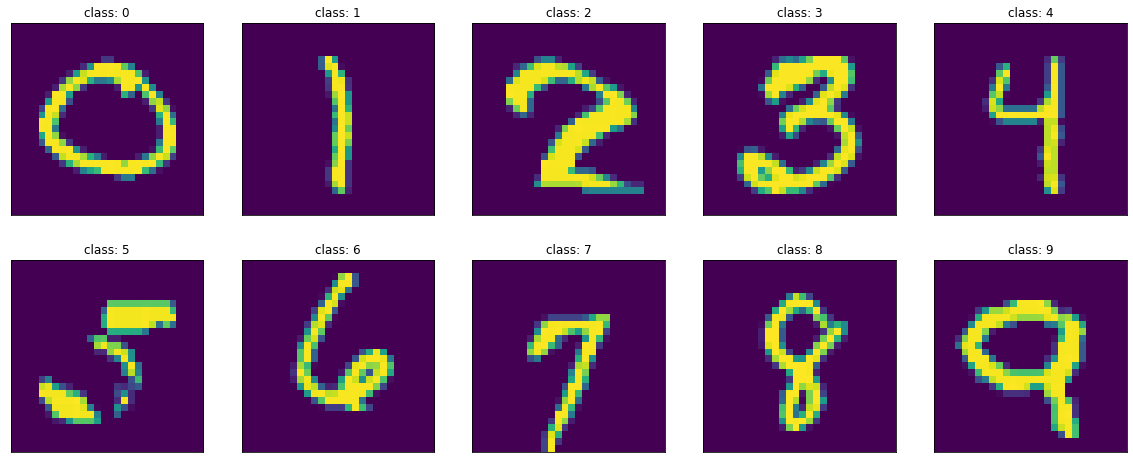

Test


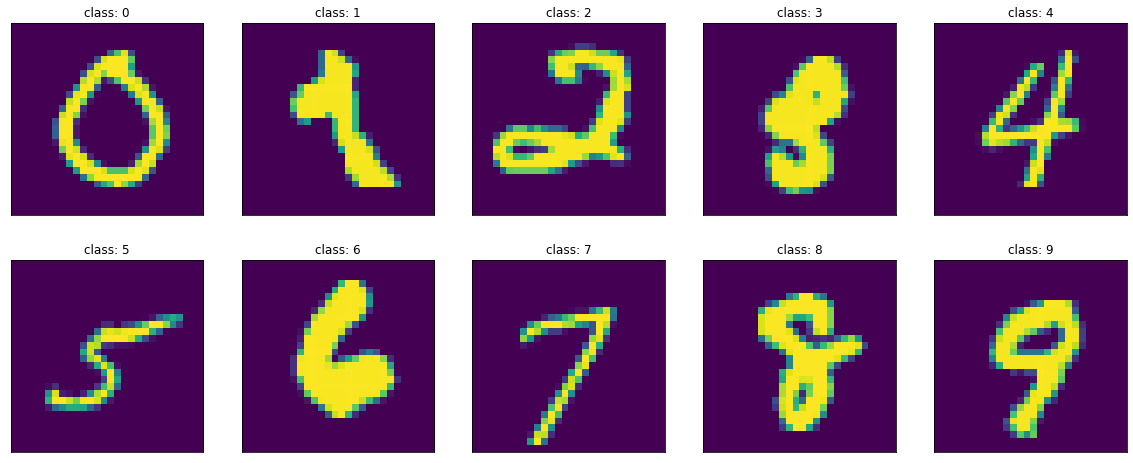

cnn_use_do False, cnn_use_bn True, cnn_activation relu, scheduler step, reg_coef 0.001, learning_rate 0.001, optimizer adam, use_transforms True


Epoch 1/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 2/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 3/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 4/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 5/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 6/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 7/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 8/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 9/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 10/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 11/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 12/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 13/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 14/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 15/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 16/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 17/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 18/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 19/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 20/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 21/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 22/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 23/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 24/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 25/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 26/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 27/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 28/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 29/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 30/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 31/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 32/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 33/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 34/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 35/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 36/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 37/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 38/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 39/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 40/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 41/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 42/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 43/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 44/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 45/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 46/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 47/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 48/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 49/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 50/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 51/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 52/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 53/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 54/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 55/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 56/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 57/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 58/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 59/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 60/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 61/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 62/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 63/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 64/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 65/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 66/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 67/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 68/500:   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 69/500:   0%|          | 0/493 [00:00<?, ?it/s]

Best val metric: 0.1204611, best hyperparams: cnn_use_do False, cnn_use_bn True, cnn_activation relu, scheduler step, reg_coef 0.001, learning_rate 0.001, optimizer adam, use_transforms True


In [40]:
os.makedirs(WORK_DIR + 'models', exist_ok=True)
os.makedirs(WORK_DIR + 'history', exist_ok=True)

# Создание датасетов
train_dataset = DefectsDataset('train')
val_dataset = DefectsDataset('val')
test_dataset = DefectsDataset('test')

# Создание лоадеров для разбиение на батчи
train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, worker_init_fn=seed_worker, generator=G)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Визуализация примеров
show_examples(train_dataset, 'Train')
show_examples(val_dataset, 'Val')
show_examples(test_dataset, 'Test')

run_record = {}

# Цикл перебора гиперпараметров
for hyp in HYPS:
    
    print((dict2str(hyp)))
    
    # Создание модели

    model_path = (f'{WORK_DIR}models/{MODEL_NAME}_{dict2str(hyp)}.pth')

    model = CNN(**extract_parameters(hyp, 'cnn'))
          
    model = model.to(DEVICE)
    
    # Выбор трасформаций
    
    if hyp['use_transforms']:
        train_dataset = DefectsDataset('train', transforms=TR)
    else:
        train_dataset = DefectsDataset('train')

    train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, worker_init_fn=seed_worker, generator=G)
        
    callbacks = [EarlyStop(f'Val loss', 8, 'min'), SaveBest(f'Val loss', model_path, 'min')]
    
    # Выбор оптимизатора
    
    if hyp['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=hyp['learning_rate'], weight_decay=hyp['reg_coef'])
    elif hyp['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=hyp['learning_rate'], momentum=0.9, weight_decay=hyp['reg_coef'])
    
    # Выбор правила изменения шага обучения
    
    if hyp["scheduler"] == "step":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                  mode='min',
                                                                  patience=5,
                                                                  min_lr=1e-6,
                                                                  factor=0.1)
    else:
        lr_scheduler=None
    
    # Обучение
    
    history = train(model, train_loader, val_loader, optimizer,
                    epochs=EPOCHS_NUM, callbacks=callbacks, lr_scheduler=lr_scheduler)
    
    # Запись результатов
    
    run_record[model_path] = {'hyperparams':hyp,
                              'history': history,
                              'final_val_metric': callbacks[1].best_monitor}
    
    with open(f'{WORK_DIR}history/{MODEL_NAME}.json', 'w') as fp:
        json.dump(run_record, fp)

    model = None
    optimizer = None

    torch.cuda.empty_cache()

# Определение лучшей модели

best_val_metric = None
best_hyperparams = None
best_run = None
best_model_path = None

for key, train_info in run_record.items():
    if best_val_metric is None or best_val_metric > train_info['final_val_metric']:
        best_val_metric = train_info['final_val_metric']
        best_hyperparams = train_info['hyperparams']
        best_run = train_info
        best_model_path = key

with open(f'{WORK_DIR}history/{MODEL_NAME}.json', 'w') as fp:
    json.dump(run_record, fp)
        
print("Best val metric: %4.7f, best hyperparams: %s" % (best_val_metric, dict2str(best_hyperparams)))

model = CNN(**extract_parameters(best_hyperparams, 'cnn'))

model.load_state_dict(torch.load(best_model_path))
torch.save(model.state_dict(), f'{WORK_DIR}models/{MODEL_NAME}.pth')
model = model.to(DEVICE)

# Print model

In [42]:
print(model)

CNN(
  (layers): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0, inplace=False)
    (4): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=392, out_features=10, bias=True)
  )
)


# Evaluate model

In [43]:
with torch.no_grad():
    preds_train = predict(train_loader, model)
    evaluate_train = evaluate(*preds_train)
    preds_val = predict(val_loader, model)
    evaluate_val = evaluate(*preds_val)
    preds_test = predict(test_loader, model)
    evaluate_test = evaluate(*preds_test)

print("Train loss: {:.7f}".format(evaluate_train[0]))  
print("Train {}: {:.7f}".format(METRIC_NAME, evaluate_train[1]))

print("Val loss: {:.7f}".format(evaluate_val[0]))  
print("Val {}: {:.7f}".format(METRIC_NAME, evaluate_val[1]))

print("Test loss: {:.7f}".format(evaluate_test[0]))  
print("Test {}: {:.7f}".format(METRIC_NAME, evaluate_test[1]))

Train loss: 0.1646872
Train accuracy_score: 0.9497778
Val loss: 0.1204611
Val accuracy_score: 0.9634286
Test loss: 0.1204611
Test accuracy_score: 0.9634286


# Confusion matrix

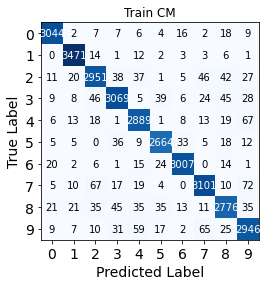

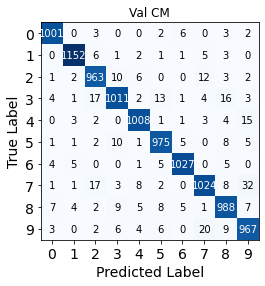

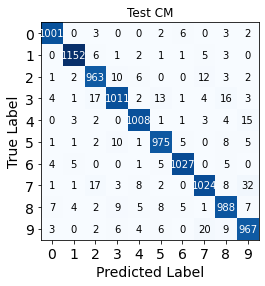

In [44]:
plot_cm(*preds_train[1:], 'Train')
plot_cm(*preds_val[1:], 'Val')
plot_cm(*preds_test[1:], 'Test')

# Plot train history

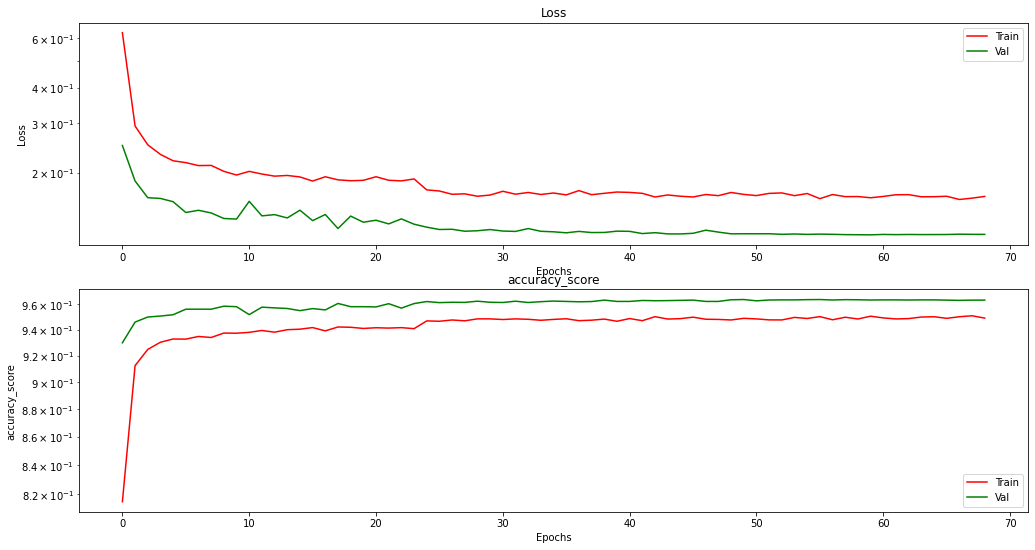

In [45]:
plot_train_history(best_run['history'])

# History analizing

[0.12046107649803162]


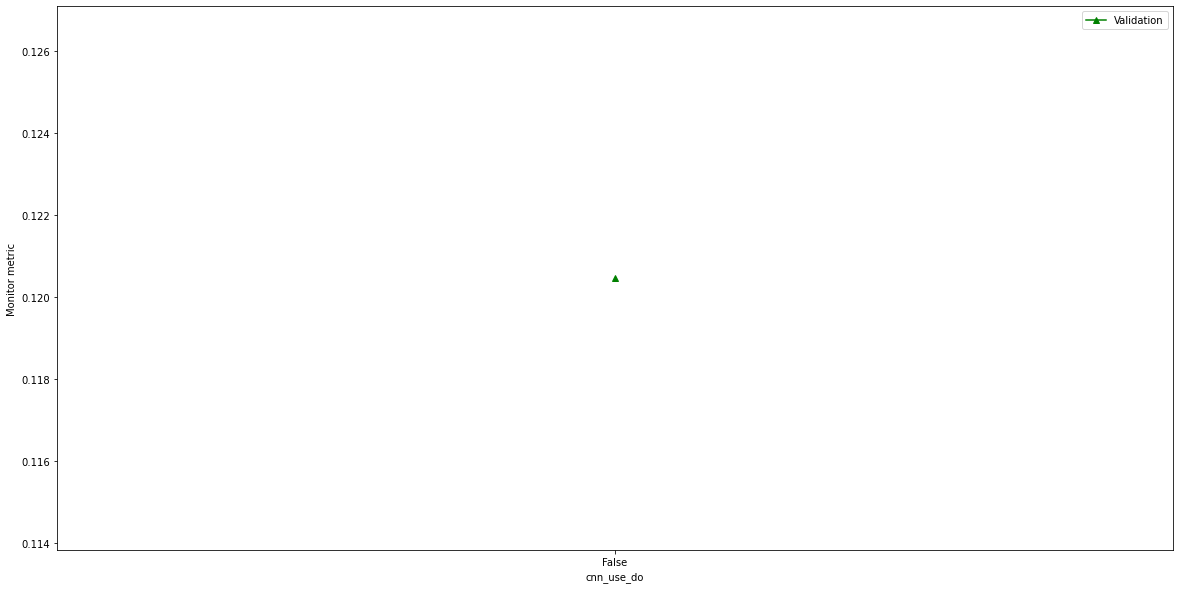

[0.12046107649803162]


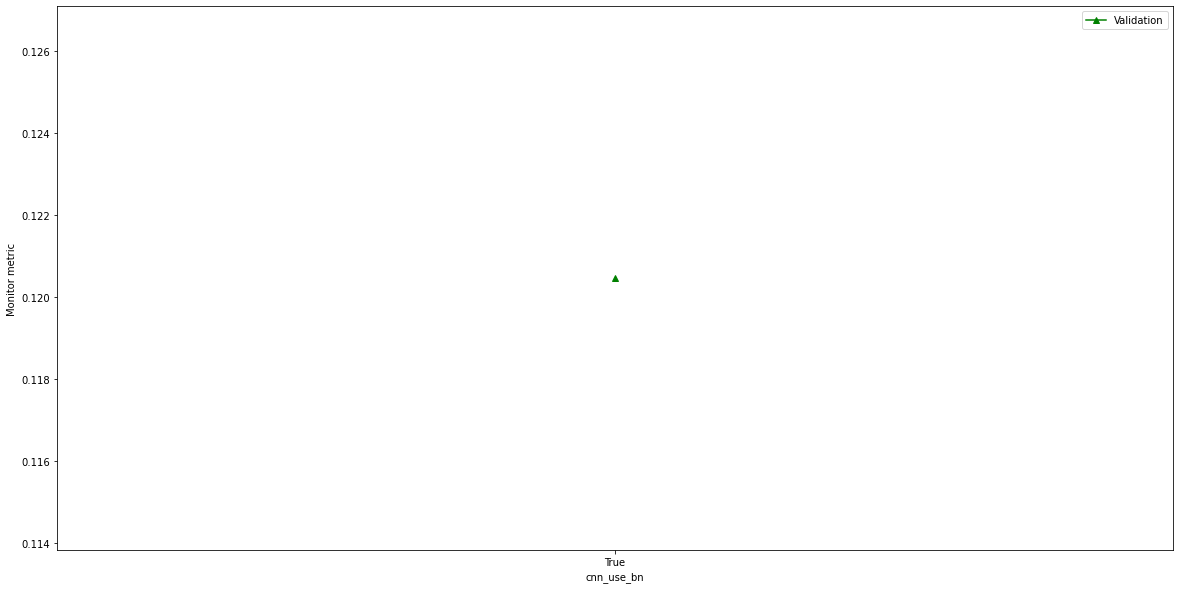

[0.12046107649803162]


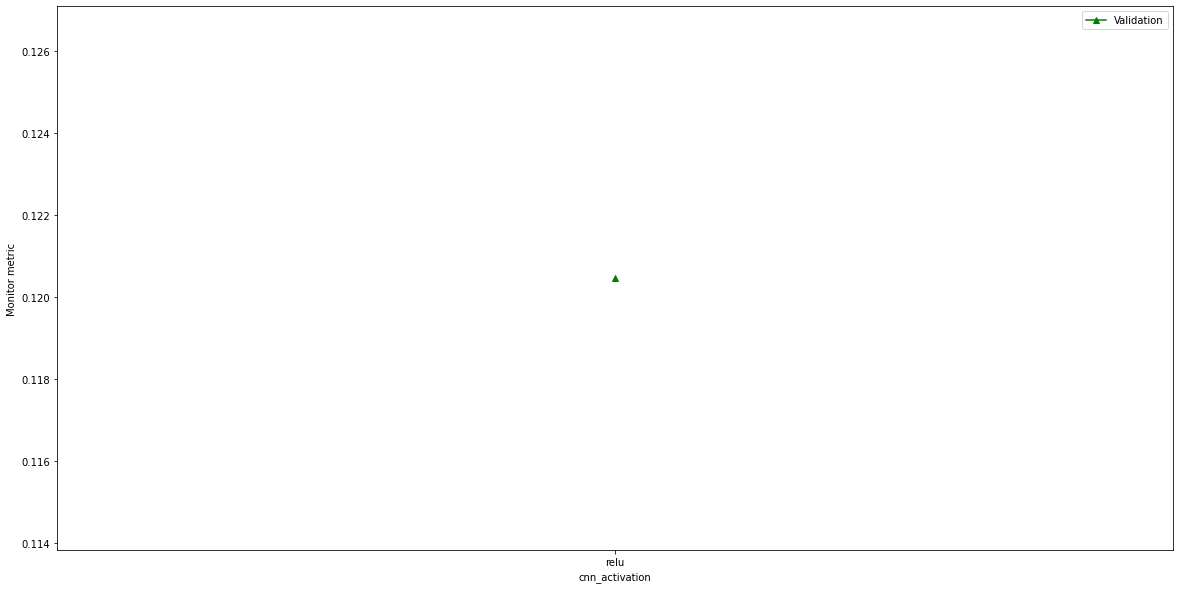

[0.12046107649803162]


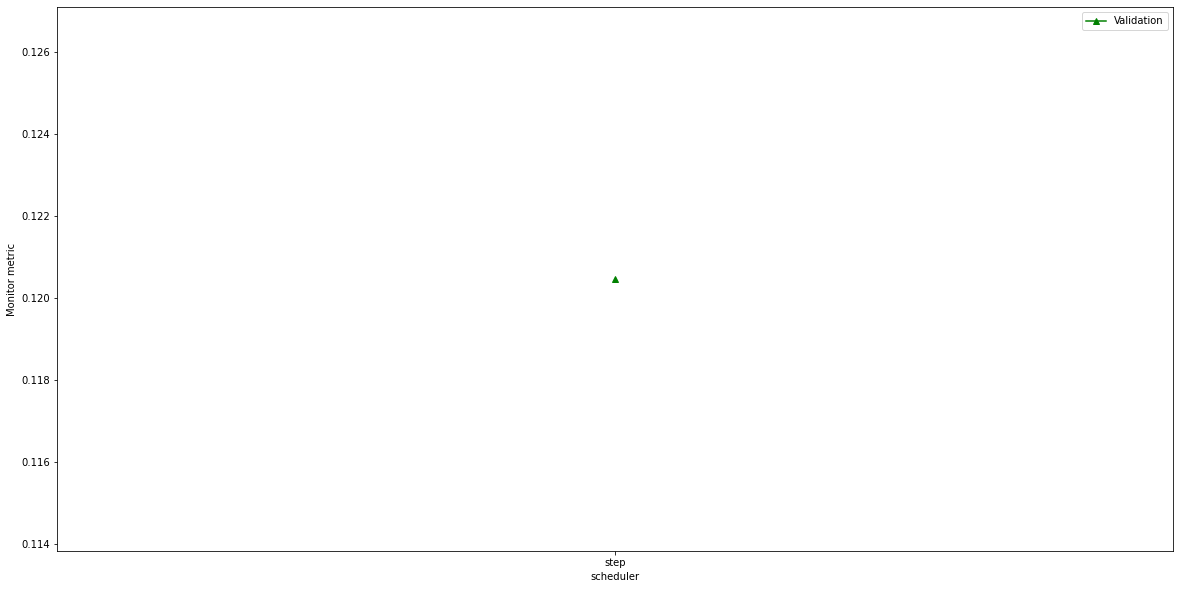

[0.12046107649803162]


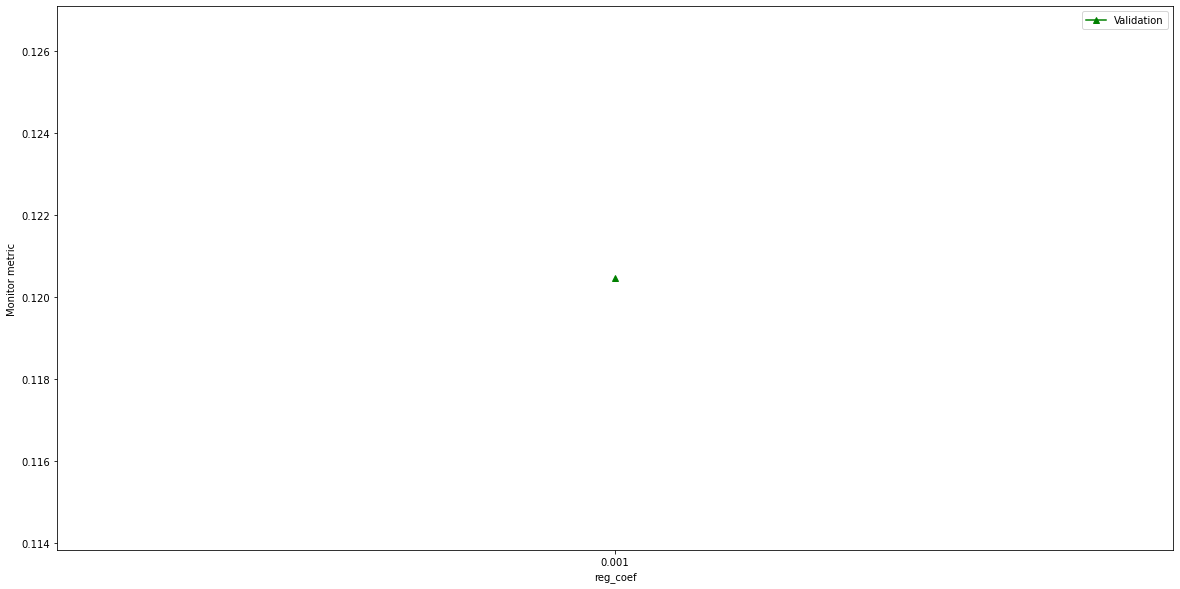

[0.12046107649803162]


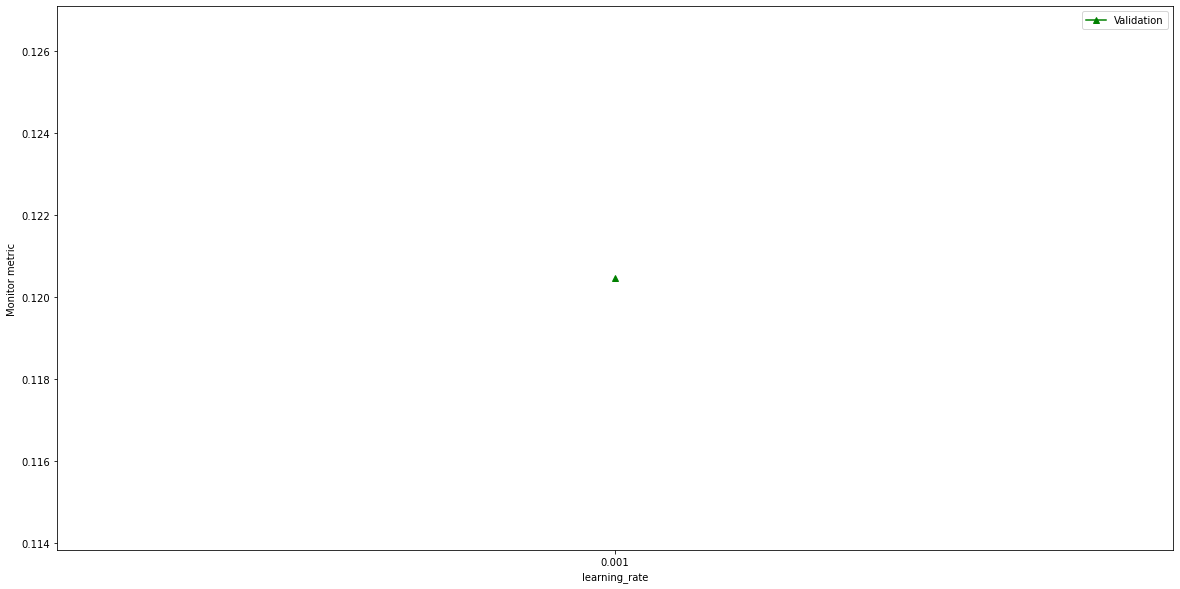

[0.12046107649803162]


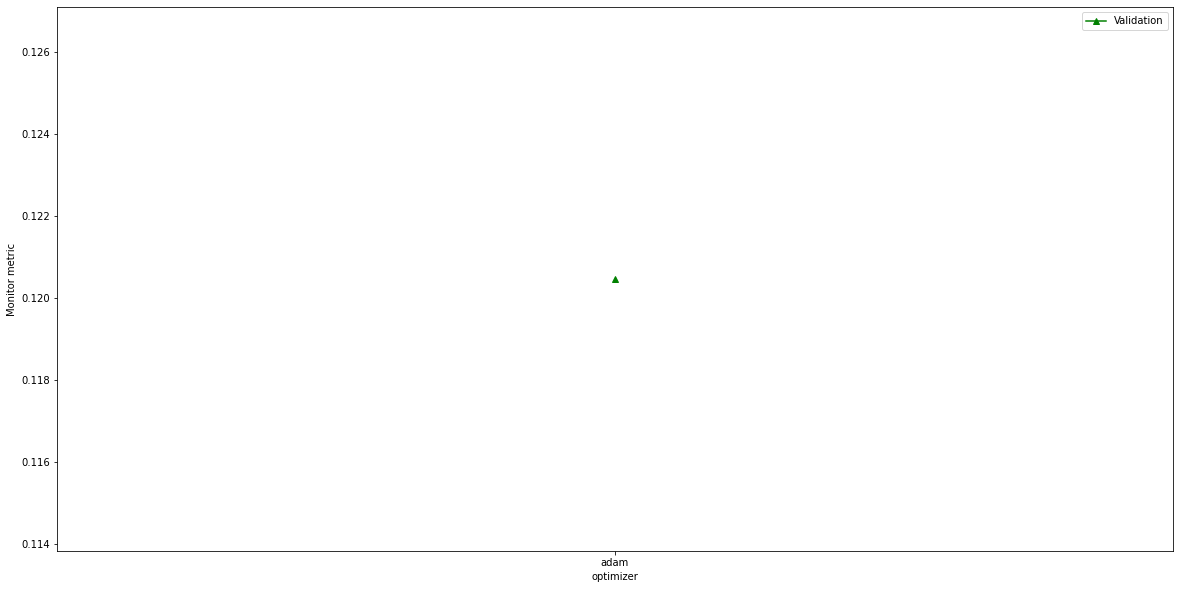

[0.12046107649803162]


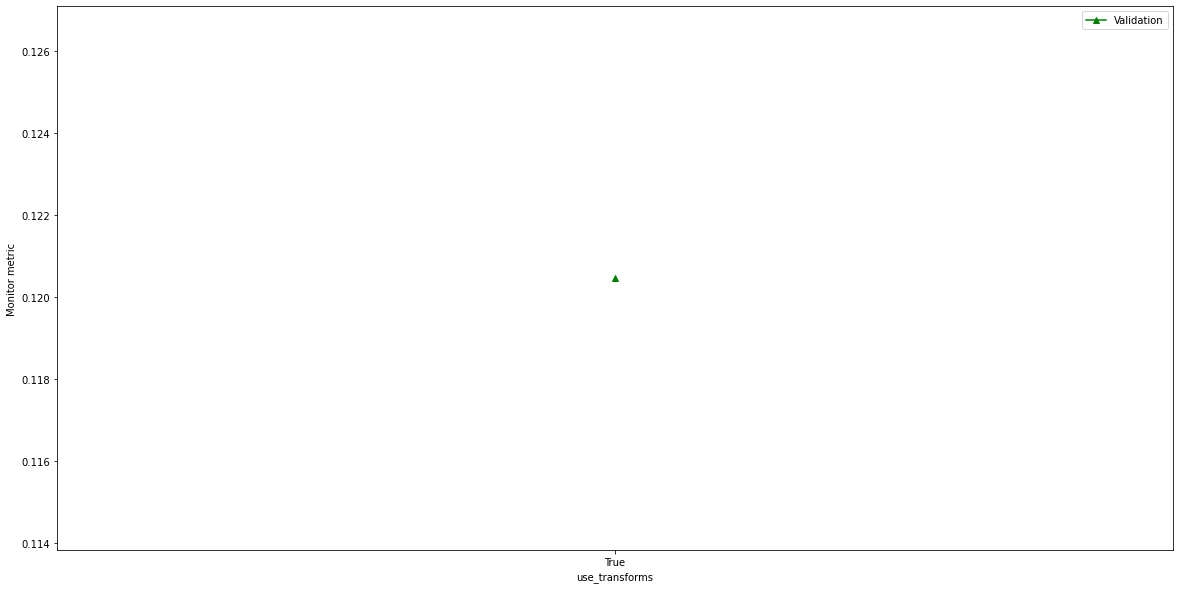

In [46]:
with open(f'{WORK_DIR}history/{MODEL_NAME}.json', 'r') as fp:
    run_record = json.load(fp)

for i in HYPS[0]:
    analize_history(run_record, [i])

Задание 5. Дописать функцию recognize. Необходимо преобразовать нарисованное изображение (self.image) с помощью TR_INF (переведет его в формат, который подходит для нейросети). Для обработки нейросетью (self.model) необходимо добавить размерность N=1 используя unsqueeze. Используйте ".to(DEVICE)" для перемещения данных GPU в случае необходимости. Выход нейросети обработать функцией torch.nn.functional.softmax для получения вероятностей. Пример работы:
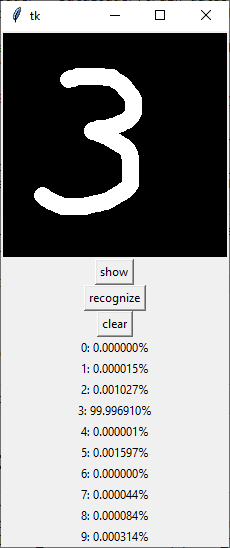
Для использования GUI необходимо запускать код локально. Для настройки лакальной серды можно использовать файл "requirements.txt", который содержит список необходимых библиотек. Для проверки кода в google colab перенестие написанный код в ячейку ниже. Для проверки вашей модели в GUI также можно передать архив, который содержит файл "Lab_7_Pytorch_MNIST_CNN.ipynb" и папку "work".

In [47]:
from tkinter import Tk, Canvas, Button, Label, YES, BOTH, ALL
from PIL import Image, ImageDraw, ImageTk


class Recognizer:
    """GUI для распознавания цифр"""
    def __init__(self, w, h, marker_size, model):
        self.marker_size = marker_size
        self.w = w
        self.h = h
        self.model = model
        
        self.root = Tk()

        self.cv = Canvas(self.root, width=self.w, height=self.h, bg='black')
        self.cv.pack(expand=YES, fill=BOTH)
        self.cv.bind("<B1-Motion>", self.paint)

        self.image = Image.new("RGB", (self.w, self.h), (0, 0, 0))
        self.draw = ImageDraw.Draw(self.image)

        button=Button(text="show", command=self.show)
        button.pack()

        button=Button(text="recognize", command=self.recognize)
        button.pack()

        button=Button(text="clear", command=self.clear)
        button.pack()
        
        self.labels = [Label(text=f"{i}: -") for i in range(10)]
        
        for i in self.labels:
            i.pack()

        self.root.mainloop()

    def paint(self, event):
        x1, y1 = (event.x + self.marker_size), (event.y + self.marker_size)
        x2, y2 = (event.x - self.marker_size), (event.y - self.marker_size)
        self.cv.create_oval(x1, y1, x2, y2, fill="white", outline="white")
        self.draw.ellipse([x2, y2, x1, y1], fill="white", outline="white")

    def recognize(self):
        # Your code here

        for i in range(10):
            self.labels[i].config(text=f'{i}: {pred[0, i] * 100:4f}%')

    def show(self):
        self.image.show()

    def clear(self):
        for i in range(10):
            self.labels[i].config(text=f'{i}: -')
        self.cv.delete(ALL)
        self.draw.rectangle([0, 0, self.w, self.h], fill="black", width=2)


recognizer = Recognizer(224, 224, 8, model)

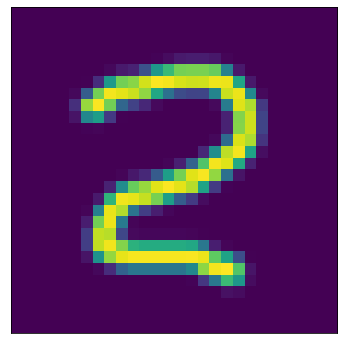

0: 100.000000%
1: 100.000000%
2: 100.000000%
3: 100.000000%
4: 100.000000%
5: 100.000000%
6: 100.000000%
7: 100.000000%
8: 100.000000%
9: 100.000000%


In [20]:
from PIL import Image, ImageDraw, ImageTk

image = Image.open('test.png')

# Your code here


plt.figure(figsize=(6, 6))

plt.imshow(TR_INF(image)[0])
plt.xticks([])
plt.yticks([])
plt.show()



for i in range(10):
    print(f'{i}: {pred[0, i] * 100:4f}%')

# Show painted image

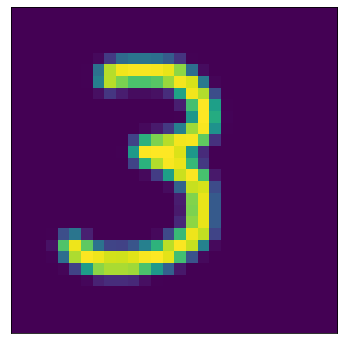

In [49]:
plt.figure(figsize=(6, 6))

plt.imshow(TR_INF(recognizer.image)[0])
plt.xticks([])
plt.yticks([])
plt.show()

*Произвести побдор гиперпараметров для обучения наилучшей модели.

**Использовать другие известные архитектуры, либо придумать свою.